# Прогнозування відвідуваності студентів за допомогою нейромережі

У цьому ноутбуці буде виконано повний цикл побудови моделі регресії для прогнозування кількості студентів на парі на основі синтетичного датасету.

## 1. Імпорт бібліотек та завантаження даних

Імпортуємо необхідні бібліотеки та завантажимо синтетичний датасет.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras

# Завантаження датасету
file_path = 'synthetic_student_attendance.csv'
df = pd.read_csv(file_path)
df.head()

,День_тижня,Час_пари,Важливість_у_навчанні,Важливість_у_житті,Строгість_викладача,Відмічають_присутність,Дощ,Температура,Контрольна_або_залік,Вихідний_напередодні,Вихідний_завтра,Подія,Тижнів_до_екзамену,Попередня_пара,Наступна_пара,Тип_пари,Відвідуваність
0,Четвер,13:30,1,5,4,1,1,-7,0,0,0,0,6,1,1,Лекція,24
1,Понеділок,10:10,1,4,2,1,1,35,0,1,1,0,10,1,0,Лабораторна,23
2,Пʼятниця,18:10,1,5,2,1,1,26,0,0,1,0,13,1,0,Лекція,21
3,Вівторок,13:30,3,4,3,0,0,14,0,1,1,0,1,0,1,Лекція,31
4,Вівторок,11:50,3,4,3,1,1,29,1,1,1,0,10,1,0,Лекція,36


## 2. Базовий аналіз даних

Оглянемо розподіл цільової змінної, кореляції та пропуски.

День_тижня                0
Час_пари                  0
Важливість_у_навчанні     0
Важливість_у_житті        0
Строгість_викладача       0
Відмічають_присутність    0
Дощ                       0
Температура               0
Контрольна_або_залік      0
Вихідний_напередодні      0
Вихідний_завтра           0
Подія                     0
Тижнів_до_екзамену        0
Попередня_пара            0
Наступна_пара             0
Тип_пари                  0
Відвідуваність            0
dtype: int64


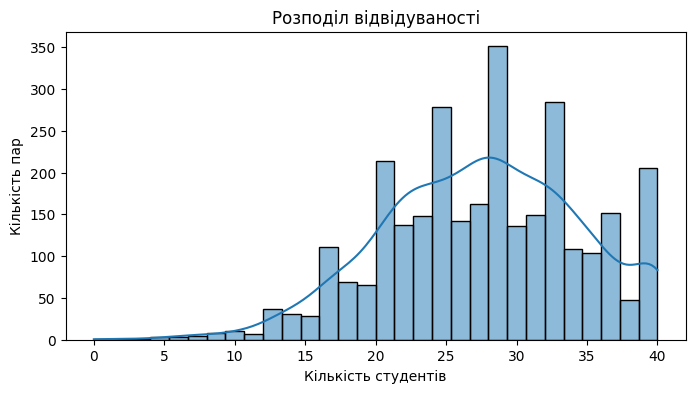

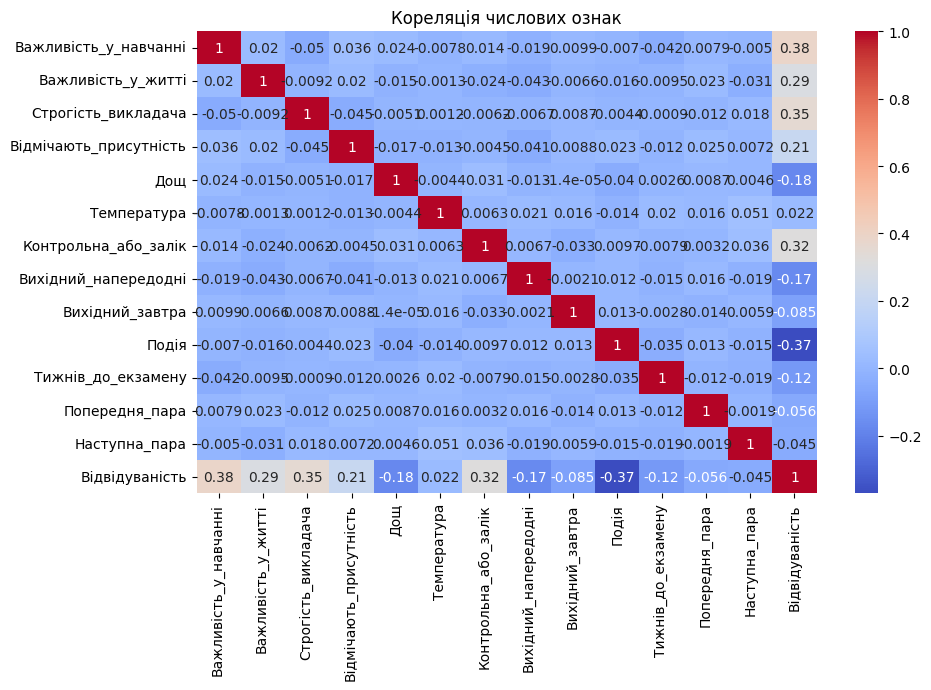

In [2]:
# Перевірка пропусків
print(df.isnull().sum())

# Розподіл цільової змінної
plt.figure(figsize=(8,4))
sns.histplot(df['Відвідуваність'], bins=30, kde=True)
plt.title('Розподіл відвідуваності')
plt.xlabel('Кількість студентів')
plt.ylabel('Кількість пар')
plt.show()

# Кореляція числових ознак
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Кореляція числових ознак')
plt.show()

## 3. Підготовка даних

Кодування категоріальних ознак, масштабування числових, розділення на train/test.

In [3]:
# Визначаємо ознаки
X = df.drop('Відвідуваність', axis=1)
y = df['Відвідуваність']

# Категоріальні та числові ознаки
categorical_features = [
    'День_тижня', 'Час_пари', 'Тип_пари'
]
numeric_features = [
    'Важливість_у_навчанні', 'Важливість_у_житті', 'Строгість_викладача',
    'Температура', 'Тижнів_до_екзамену'
]
binary_features = [
    'Відмічають_присутність', 'Дощ', 'Контрольна_або_залік',
    'Вихідний_напередодні', 'Вихідний_завтра', 'Подія',
    'Попередня_пара', 'Наступна_пара'
]

# Трансформер для підготовки даних
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(sparse_output=False), categorical_features),
    ('num', StandardScaler(), numeric_features),
    ('bin', 'passthrough', binary_features)
])

X_prepared = preprocessor.fit_transform(X)

# Розділення на train/test
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (2400, 29), Test shape: (600, 29)


## 4. Побудова та навчання нейромережі

Створимо просту нейромережу для регресії на TensorFlow/Keras.

In [ ]:
# Покращена архітектура моделі з Dropout, BatchNormalization та L2 регуляризацією
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Побудова покращеної моделі
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    
    # Перший прихований шар
    keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.3),
    
    # Другий прихований шар
    keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.2),
    
    # Третій прихований шар
    keras.layers.Dense(32, kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.1),
    
    # Четвертий прихований шар
    keras.layers.Dense(16, activation='relu'),
    
    # Вихідний шар
    keras.layers.Dense(1)
])

# Компіляція з оптимізатором Adam та налаштуванням learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks для покращення навчання
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# Навчання з callbacks
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Виведення структури моделі
model.summary()

Epoch 1/200


2025-12-15 02:02:48.754621: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-12-15 02:02:48.754676: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-15 02:02:48.754698: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-15 02:02:48.754729: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-15 02:02:48.754763: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-12-15 02:02:49.243333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 571.6033 - mae: 22.7852 - val_loss: 507.5178 - val_mae: 21.8603 - learning_rate: 0.0010
Epoch 2/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 133.9954 - mae: 9.7949 - val_loss: 112.9209 - val_mae: 9.8252 - learning_rate: 0.0010
Epoch 3/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 36.7418 - mae: 4.8416 - val_loss: 57.5290 - val_mae: 6.6954 - learning_rate: 0.0010
Epoch 4/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 31.4391 - mae: 4.4411 - val_loss: 34.6493 - val_mae: 4.9576 - learning_rate: 0.0010
Epoch 5/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 29.1089 - mae: 4.2653 - val_loss: 19.1206 - val_mae: 3.5461 - learning_rate: 0.0010
Epoch 6/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 28.3159 - mae: 4.1603 - val_loss: 20.6299 - val_mae: 3.7646 - learning_rate: 0.0010
Epoch 7/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 23.0975 - mae: 3.7912 - val_loss: 18.3504 - val_mae: 3.4763 - learni

## 5. Оцінка якості моделі

Оцінимо якість моделі на тестовій вибірці та побудуємо графік «реальні vs передбачені».

In [ ]:
# Оцінка на тестовій вибірці
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE: {mae:.2f}")

# Прогнозування
preds = model.predict(X_test).flatten()

# Метрики
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# Графік історії навчання
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Історія навчання: Loss')
axes[0].legend()
axes[0].grid(True)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE')
axes[1].plot(history.history['val_mae'], label='Val MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Історія навчання: MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Графік "реальні vs передбачені"
plt.figure(figsize=(8, 6))
plt.scatter(y_test, preds, alpha=0.5, edgecolors='k', linewidth=0.5)
plt.xlabel('Реальні значення')
plt.ylabel('Передбачені')
plt.title(f'Реальні vs Передбачені (MAE={mae:.2f}, RMSE={rmse:.2f})')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ідеальна лінія')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Розподіл помилок
errors = y_test - preds
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(errors, bins=30, kde=True)
plt.xlabel('Помилка (реальне - передбачене)')
plt.ylabel('Частота')
plt.title('Розподіл помилок')
plt.axvline(x=0, color='r', linestyle='--')

plt.subplot(1, 2, 2)
plt.scatter(preds, errors, alpha=0.5)
plt.xlabel('Передбачені значення')
plt.ylabel('Помилка')
plt.title('Залишки vs Передбачені')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Детальна статистика помилок
print(f"\n--- Детальна статистика помилок ---")
print(f"Середня помилка: {np.mean(errors):.2f}")
print(f"Стандартне відхилення: {np.std(errors):.2f}")
print(f"Мінімальна помилка: {np.min(errors):.2f}")
print(f"Максимальна помилка: {np.max(errors):.2f}")
print(f"Медіана помилки: {np.median(errors):.2f}")

## 6. Збереження моделі та приклад використання

In [ ]:
# Збереження моделі
model.save('student_attendance_model.keras')
print("Модель збережено у файл 'student_attendance_model.keras'")

# Приклад використання моделі для прогнозування
print("\n--- Приклад прогнозування ---")
sample_idx = np.random.choice(len(X_test), 5, replace=False)
sample_X = X_test[sample_idx]
sample_y = y_test.iloc[sample_idx].values
sample_preds = model.predict(sample_X, verbose=0).flatten()

for i, (real, pred) in enumerate(zip(sample_y, sample_preds)):
    print(f"Приклад {i+1}: Реальне = {real}, Передбачене = {pred:.1f}, Різниця = {abs(real - pred):.1f}")

## 7. Висновки

**Покращення, які було внесено:**

1. **Глибша архітектура** — 4 приховані шари (128 → 64 → 32 → 16 нейронів)
2. **BatchNormalization** — нормалізація активацій для стабільнішого навчання
3. **Dropout** — регуляризація для боротьби з перенавчанням (0.3 → 0.2 → 0.1)
4. **L2 регуляризація** — додаткова регуляризація ваг
5. **EarlyStopping** — автоматична зупинка при відсутності покращення
6. **ReduceLROnPlateau** — зменшення learning rate при плато
7. **Менший batch_size** (16) — більш точні градієнти
8. **Більше епох** (до 200) з ранньою зупинкою

**Метрики:**
- MAE показує середню абсолютну помилку прогнозування (у студентах)
- RMSE враховує великі помилки сильніше

**Рекомендації для подальшого покращення:**
- Збільшити розмір датасету
- Додати feature engineering (взаємодії між ознаками)
- Спробувати ансамблеві методи (градієнтний бустинг, XGBoost)